# Setup and imports

Please jump to the next section.

In [2]:
%matplotlib inline

In [3]:
!pip install -q pysoundfile pydub

In [4]:
# Standard import 

import numpy as np, scipy, matplotlib.pyplot as plt, sklearn, IPython.display as ipd
import librosa, librosa.display, soundfile as sf
import urllib
import warnings
warnings.simplefilter("ignore")

In [5]:
# Audio recording from
# https://gist.github.com/korakot/c21c3476c024ad6d56d5f48b0bca92be
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode
from io import BytesIO
from pydub import AudioSegment

import functools
import scipy.signal

import torch
import torch.nn.functional as F

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=3):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1000))
  b = b64decode(s.split(',')[1])
  audio = AudioSegment.from_file(BytesIO(b))
  x = np.array(audio.get_array_of_samples()).astype(np.float32)
  x /= np.abs(x).max()
  sr = audio.frame_rate
  return x, sr

In [6]:
def load_url(url):
    fname = url.split('/')[-1]
    urllib.request.urlretrieve(url, filename=fname)
    return librosa.load(fname, sr=None)

# Speech feature intuitions

The following notebook builds some intuitions about feature extraction commonly used to process speech

Let's first load a speech utterance, then listen and look at it.

In [7]:
x_bell, sr_bell = load_url('https://upload.wikimedia.org/wikipedia/commons/c/cd/Dicker_Peter_links_Bukarestglocke_rechts.ogg')
x, sr = x_bell, sr_bell
ipd.Audio(x, rate=sr)

Output hidden; open in https://colab.research.google.com to view.

The speech data is just an array of floats. It gives the instantenous air pressures recorded by the microphone. The sampling rate tells us how often they were sampled, and hence allows us to reason about their frequencies. Changing the sample rate changes the duration and pitch of the recording:

In [8]:
ipd.Audio(x, rate=sr*2)

Output hidden; open in https://colab.research.google.com to view.

x is a <class 'numpy.ndarray'> containing (1181326,) elements of float32.
Min is -0.31769490242004395 and max 0.30187469720840454


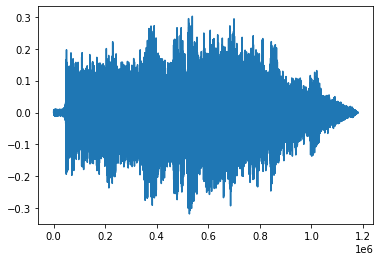

In [9]:
print(f'x is a {type(x)} containing {x.shape} elements of {x.dtype}.\n'
      f'Min is {x.min()} and max {x.max()}')

plt.plot(x)

## Frequency analysis

When $x$ is plotted as a waveform we can see its volume but it is hard to reason about the structure of the sound.

An alternative view, computed using the [Fourier Transform](https://en.wikipedia.org/wiki/Fourier_transform) gives us the frequencies present in a signal.

Let's now apply FT to the bells 

Text(0, 0.5, 'amplitude')

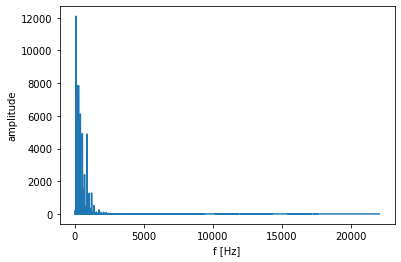

In [10]:
x, sr = x_bell, sr_bell
x_fft = np.fft.rfft(x)
plt.plot(np.fft.rfftfreq(len(x), 1.0/sr), np.abs(x_fft))
plt.xlabel('f [Hz]')
plt.ylabel('amplitude')

FT of artificial signals

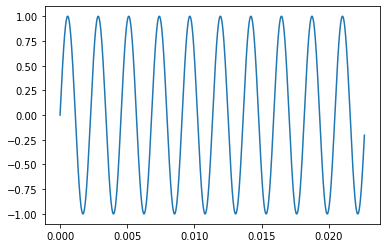

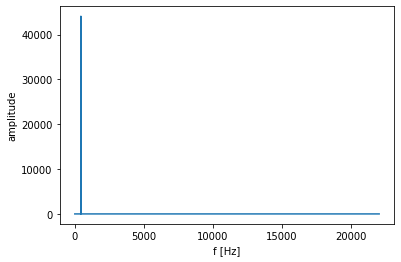

In [11]:
t = np.arange(0,2, 1.0/sr)
# A pure tone
x = np.sin(2*np.pi*440*t)
plt.figure()
plt.plot(t[:1000], x[:1000])

x_fft = np.fft.rfft(x)

plt.figure()
plt.plot(np.fft.rfftfreq(len(x), 1.0/sr), np.abs(x_fft))
plt.xlabel('f [Hz]')
plt.ylabel('amplitude')

ipd.Audio(x, rate=sr)

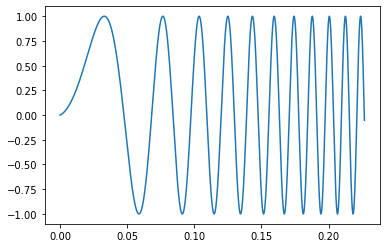

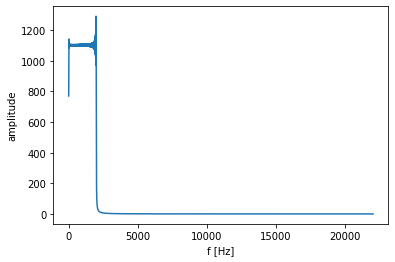

In [12]:
t = np.arange(0,5, 1.0/sr)
# A linear chirp
x = np.sin(2*np.pi*(200*t**2 + 1*t))

plt.figure()
plt.plot(t[:10000], x[:10000])

x_fft = np.fft.rfft(x)

plt.figure()
plt.plot(np.fft.rfftfreq(len(x), 1.0/sr), np.abs(x_fft))
plt.xlabel('f [Hz]')
plt.ylabel('amplitude')

ipd.Audio(x, rate=sr)

### Short-Time Fourier Transform (STFT)

Fourier Transform shows us which frequencies are present in the signal but we lose the information about their timing. 

The Short-Time Fourier Transform (STFT) aims to provide both time and frequency information by performing the FT over small overlapping fragments of the recording. Hence, it provides us with a *time-frequency* wiev of the audio. The window length controls the tradeoff between good time resolution (short windows) and good frequency resolution (wide windows).

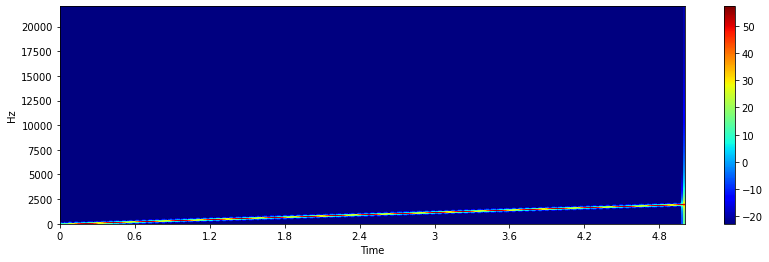

In [13]:
# The stft shows the evolution of the frequencies in the signal over time
S = librosa.stft(x)
S_db = librosa.amplitude_to_db(abs(S))
plt.figure(figsize=(14, 4))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='linear', cmap='jet')
plt.colorbar()

Let's repeat STFT on the bells recording.

Please note that on the plot of the bell the STFT clearly shows the moments when the bell was struck.

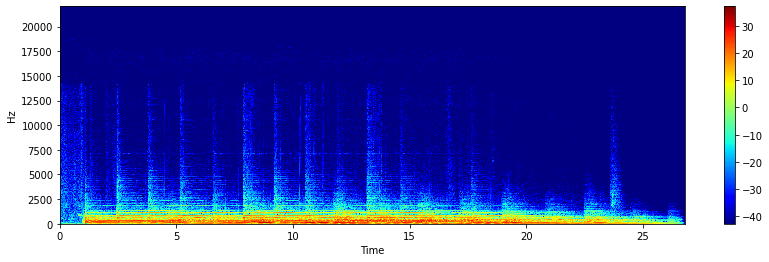

In [14]:
x, sr = x_bell, sr_bell
S = librosa.stft(x)
S_db = librosa.amplitude_to_db(abs(S))
plt.figure(figsize=(14, 4))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='linear', cmap='jet')
plt.colorbar()

Now for some speech signal

In [15]:
# Vowel a

x_speech_a, sr_speech_a = load_url('https://upload.wikimedia.org/wikipedia/commons/e/e5/Open_back_unrounded_vowel.ogg')
x, sr = x_speech_a, sr_speech_a
ipd.Audio(x, rate=sr)

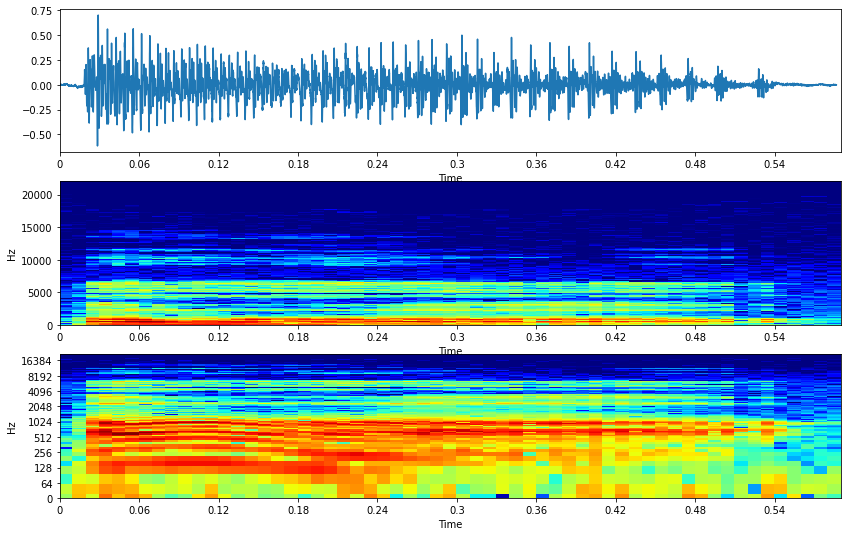

In [16]:
fft_params = dict(n_fft=int(sr  * 25e-3), hop_length=int(sr * 10e-3))
S = librosa.stft(x, **fft_params)
S_db = librosa.amplitude_to_db(abs(S))

plt.figure(figsize=(14, 9))
plt.subplot(3,1,1)
plt.plot(np.arange(len(x)* 1.0)/sr, x)
plt.xlabel('Time')

plt.subplot(3,1,2, sharex=plt.gca())
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='linear', hop_length=fft_params['hop_length'], cmap='jet')


plt.subplot(3,1,3, sharex=plt.gca())
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log', hop_length=fft_params['hop_length'], cmap='jet')

In [17]:
x, sr = load_url('http://www.ee.columbia.edu/~dpwe/e6820/sounds/mpgr1_sx419-8k.wav')
ipd.Audio(x, rate=sr)

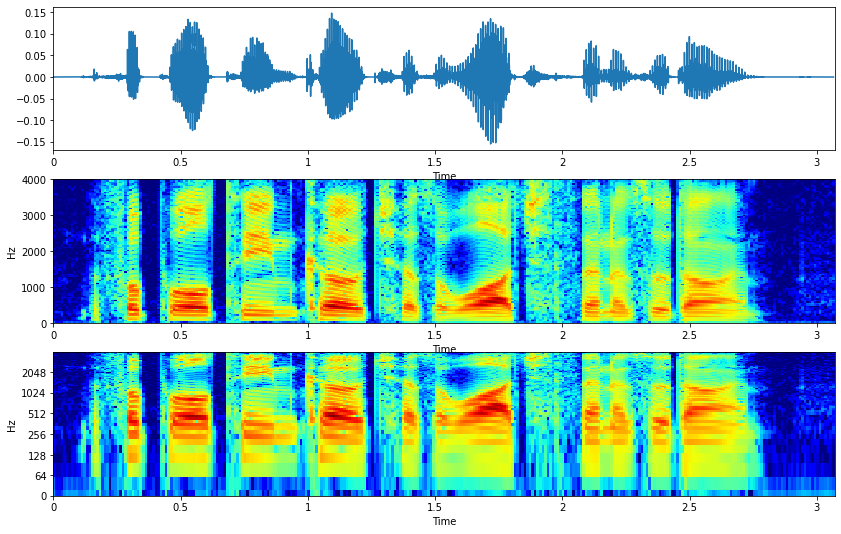

In [18]:
fft_params = dict(n_fft=int(sr  * 25e-3), hop_length=int(sr * 10e-3))
S = librosa.stft(x, **fft_params)
S_db = librosa.amplitude_to_db(abs(S))

plt.figure(figsize=(14, 9))
plt.subplot(3,1,1)
plt.plot(np.arange(len(x)* 1.0)/sr, x)
plt.xlabel('Time')

plt.subplot(3,1,2, sharex=plt.gca())
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='linear', hop_length=fft_params['hop_length'], cmap='jet')


plt.subplot(3,1,3, sharex=plt.gca())
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log', hop_length=fft_params['hop_length'], cmap='jet')

(1.3, 2.8)

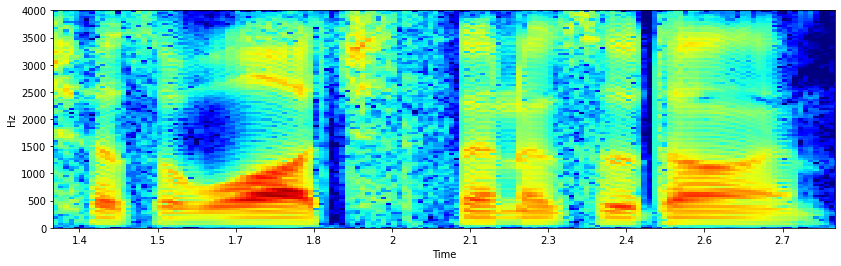

In [19]:
fft_params = dict(n_fft=int(sr  * 25e-3), hop_length=int(sr * 10e-3))
S = librosa.stft(x, **fft_params)
S_db = librosa.amplitude_to_db(abs(S))
plt.figure(figsize=(14, 4))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='linear', hop_length=fft_params['hop_length'], cmap='jet')
#plt.colorbar()
plt.xlim(1.3, 2.8)

# Audio features extraxction using neural operations

The typical audio pipeline consists of:
1. Extracting small, overlapping segments of the recording (windows)
2. Multiplying the windows by a [Window function](https://en.wikipedia.org/wiki/Window_function) which downweights the edges of the window, e.g.
  $$
    w_n = 0.5\left[1-\cos\left(\frac{2\pi}{N}n\right)\right]
  $$
3. Applying the Discrete Fourier Transform:
   $$
       X_k = \sum_{n=0}^{N-1}x_n \cdot w_n
       \left[\cos\left(\frac{2\pi}{N}kn\right)
       -i\cdot\sin\left(\frac{2\pi}{N}kn\right)\right]
   $$
   Please note that this can be seen as a convolution between the samples $x_n$ and a set of sinusoida and cosinusoidal filters. Thus, we can implement it using `torch.nn.functional.conv1d`.
4. Keeping the magnitude of the complex DFT values.
5. Scaling the frequencies accorfing to the Mel scale, this again will correspond to a 1D width-1 convolution.
6. Applying the log scale to the magnitudes (decibels)

In [20]:
# Based on tensor2tensor implementation (Apache Licensed)
# https://github.com/tensorflow/tensor2tensor/blob/master/tensor2tensor/layers/common_audio.py
class SpeechFeatures(torch.nn.Module):
    def __init__(self, 
                 sample_rate=16000,
                 dither=1.0 / np.iinfo(np.int16).max, preemphasis=0.97,
                 frame_length=25, frame_step=10, 
                 window_fn=functools.partial(scipy.signal.hann, sym=False),
                 lower_edge_hertz=80.0, upper_edge_hertz=7600.0, num_mel_bins=80,
                 log_noise_floor=1e-3, add_energy=False):
        super().__init__()
        self._dither = dither
        self._preemphasis = preemphasis    

        self._frame_length = int(sample_rate * frame_length / 1e3)
        self._frame_step = int(sample_rate * frame_step / 1e3)
        self.register_buffer(
            '_dft_kernel', self.dft_kernel(self._frame_length, window_fn))

        if num_mel_bins > 0:
            mel = librosa.filters.mel(
                sr, n_fft=200, n_mels=num_mel_bins, 
                fmin=lower_edge_hertz, fmax=upper_edge_hertz)
            
            # Treat the mel as length-1 convolution kernel
            self.register_buffer(
                '_mel_basis', torch.from_numpy(mel).float().unsqueeze(-1))
            self._log_noise_floor = log_noise_floor
        else:
            self.register_buffer('_mel_basis', None)
        
        self._add_energy = add_energy
    
    @staticmethod
    def dft_kernel(n_fft, window_fn):
        """Create a conv kernel that computes the DFT.
        
        Returns a tensor of shape:
        - (n_fft // 2 + 1) * 2 (real components of the DFT followed by imaginary)
        - 1 (input channel)
        - n_fft (input length)
        """
        two_pi_n = 2.0 * np.pi / n_fft
        # the k DFT components, due to FFT symmetry we only keep n_fft //2 +1
        k = torch.arange(n_fft // 2 + 1, dtype=torch.float).view(-1, 1, 1)
        # the window width
        n = torch.arange(n_fft, dtype=torch.float).view(1, 1, -1)
        grid = two_pi_n *  k * n
        real_weights = torch.cos(grid)
        imag_weights = -torch.sin(grid)
        kernel = torch.cat((real_weights, imag_weights), dim=0)
        if window_fn:
            if isinstance(window_fn, str):
                window_fn = getattr(scipy.signal, window_fn)
            window_tensor = torch.from_numpy(window_fn(n_fft)).float().view(1, 1, -1)
            kernel *= window_tensor
        return kernel
    
    def preprocess(self, x):
        """Apply dithering and pre-emphasis."""
        # Dithering adds small noise with standard deviation similar to quantizatio
        if self._dither > 0:
            x = x.add(torch.randn_like(x), alpha=self._dither)
        # Preemphasis is a high-pass filter
        if self._preemphasis > 0:
            x = x[:, 1:].add(x[:, :-1], alpha=-self._preemphasis)
        return x

    def stft(self, x):
        x.unsqueeze_(1)  # Add a single channel dimension
        # 1.-3. windowing and DFT can be implemented using a convolution
        x =  F.conv1d(x, self._dft_kernel,
                      padding=self._dft_kernel.shape[-1],
                      stride=self._frame_step)
        # 4. Take the absolute value
        # 4.1 reshape x separating real and imaginary components
        n, n_fft2, l = x.shape
        x = x.view(n, 2, n_fft2 // 2, l)
        x = torch.pow(x, 2).sum(1).add(1e-4).sqrt()
        return x

    def stft_to_mel(self, x):
        # 5. Apply the Mel frequency scale
        x = F.conv1d(x, self._mel_basis)
        # 6. Convert the amplitudes to log scale
        x = torch.log(torch.max(x, torch.tensor(self._log_noise_floor,
                                                device=x.device)))
        return x

    def forward(self, x):
        """Compute the features."""
        # 0. Signal preprocessingf: dithering + pre-emphasis
        x = self.preprocess(x)
        x = self.stft(x)
        if self._add_energy:
            energy = (x**2).sum(1, keepdim=True)
        if self._mel_basis is not None:
            x = self.stft_to_mel(x)
        if self._add_energy:
            x = torch.cat((energy, x), dim=1)
        return x

In [21]:
feats = SpeechFeatures(sr, lower_edge_hertz=0, upper_edge_hertz=None)

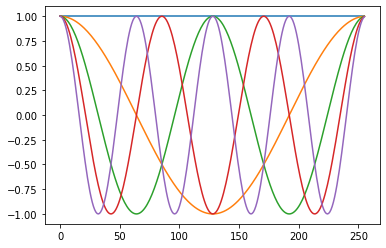

In [22]:
# Plot some FFT basis functions:
# cosines and sines of different frequencies
dft_kernel = SpeechFeatures.dft_kernel(256, None)
plt.figure()
_ = plt.plot(dft_kernel[:5,0].T)

# Notice how the filters are are cosines of increasing frequeicnies

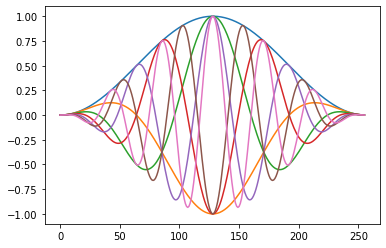

In [23]:
# With the windowing function, the filters are zero at their edges
dft_kernel = SpeechFeatures.dft_kernel(
    256, functools.partial(scipy.signal.hann, sym=False))
plt.figure()
_ = plt.plot(dft_kernel[:7,0].T)

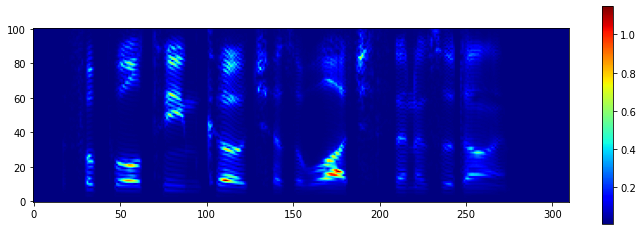

In [24]:
# The result of the STFT computation is Time x Frequency representation of speech
x_torch = torch.from_numpy(x).float().view(1, -1)
stft = feats.stft(feats.preprocess(x_torch))

plt.figure(figsize=(12,4))
plt.imshow(stft.numpy()[0], cmap='jet')
plt.colorbar()
plt.gca().invert_yaxis()

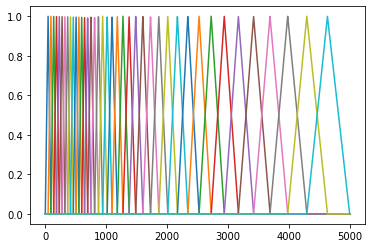

In [25]:
# Finally, compress the frequency axis according to the MEL scale
mel_basis = librosa.filters.mel(16000, 10000, 40, norm=None)
_ = plt.plot(mel_basis.T)

(-0.5, 309.5, -0.5, 79.5)

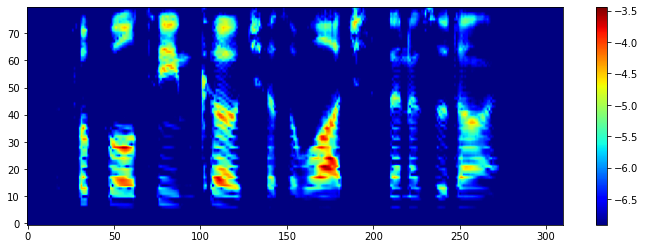

In [26]:
# The end result has good frequency resolution in the low frequencies, 
# and can be treated like an image on which convolutional nets are applied

S = feats(x_torch)

plt.figure(figsize=(12,4))
plt.imshow(S.numpy()[0], cmap='jet')
plt.colorbar()
plt.gca().invert_yaxis()
plt.axis('tight')

# Audio reconstruction

We will use the fact that we have implemented the Mel-Filterbank extraction using pytorch to slightly change it and search for an audio sequence that produces a similar filterbank.

In [27]:
x, sr = load_url('http://www.ee.columbia.edu/~dpwe/e6820/sounds/mpgr1_sx419-8k.wav')
x_torch = torch.from_numpy(x).view(1,-1)

ipd.Audio(x, rate=sr)
feats = SpeechFeatures(sr, num_mel_bins=0)

In [28]:
feats.to('cuda')

# Run the original recording through the feature extraction
# pick 1s of audio
x_orig = x_torch.to('cuda')  # [:,int(0.5 * sr): int(1.5*sr)]
feats_orig = feats(x_orig)

# Create a placeholder for reconstruction
x_rec = torch.zeros_like(x_orig)
x_rec.random_().mul_(0.1)
x_rec.requires_grad_(True)

optimizer = torch.optim.Adam([x_rec], lr=1e6)

for step in range(50000):
    optimizer.zero_grad()
    feats_rec = feats(x_rec)
    loss = torch.mean((feats_orig - feats_rec)**2)
    loss.backward()
    if (step % 1000) == 1:
        print(f'{step}: {loss.item()}, {optimizer.param_groups[0]["lr"]}')
    optimizer.step()
    optimizer.param_groups[0]['lr'] *= 0.9995

1: 104856224268288.0, 999500.0
1001: 13550030848.0, 606151.5954286763
2001: 3051739648.0, 367603.55841993843
3001: 1284770304.0, 222934.9508969524
4001: 192109312.0, 135199.97615107681
5001: 7796077.5, 81992.67758468617
6001: 4508444.5, 49724.854758805915
7001: 312925.0625, 30155.877983501014
8001: 28983.169921875, 18288.177640071663
9001: 569.942626953125, 11090.953530777855
10001: 0.002377609023824334, 6726.162258635607
11001: 0.001674158382229507, 4079.1135409545936
12001: 0.0018715150654315948, 2473.7980798242515
13001: 0.0021730458829551935, 1500.246776241984
14001: 0.0023670427035540342, 909.8318929022546
15001: 0.0022771761287003756, 551.7719394243064
16001: 0.0028605989646166563, 334.62475377170387
17001: 0.004087274428457022, 202.9347957665288
18001: 0.0028329200576990843, 123.07078561468107
19001: 0.0042055509984493256, 74.63687148674273
20001: 0.0026532169431447983, 45.263890674831394
21001: 0.0024244114756584167, 27.450504800258283
22001: 0.003985890652984381, 16.6474910255

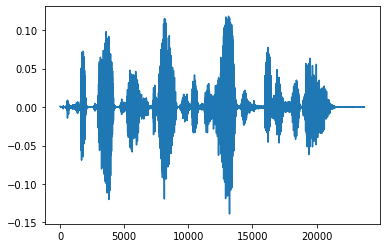

In [29]:
rec_a = x_rec.detach().cpu().numpy().ravel()
# TODO: figure why there is a spike at the beginning!
# Meanwhile, simply crop out the borders
plt.plot(rec_a[700:-100])

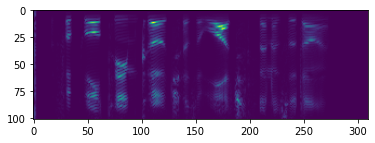

In [30]:
plt.imshow(feats_rec.detach().cpu().numpy()[0])
ipd.Audio(rec_a[700:-100], rate=sr)

Audio modification: slowing down and speeding up

In [31]:
# Simply slowing or speeding the audio changes pitch

# Play twice slower
ipd.Audio(x_orig[0].cpu(), rate=sr/2)

In [32]:
# Play twice faster 
ipd.Audio(x_orig[0].cpu(), rate=sr*2)

In [33]:
# In this cell we modify the spectrogram and try to reconstruct the audio:
# we are stretching the histogram 

# Run the original recording through the feature extraction
# pick 1s of audio
x_orig = x_torch.to('cuda')
feats_orig = feats(x_orig)

# Repeat-interleave the feats to produce a spectrogram twice as long
feats_orig = torch.stack((feats_orig, feats_orig), dim=-1).view(1, 101, -1)

# Create a placeholder for reconstruction
# start with an empty recording approximately twce as long as the original
x_rec = torch.zeros((1, 49400), device='cuda')
x_rec.random_().mul_(0.1)
x_rec.requires_grad_(True)

optimizer = torch.optim.Adam([x_rec], lr=1e6)

for step in range(50000):
    optimizer.zero_grad()
    feats_rec = feats(x_rec)
    loss = torch.mean((feats_orig - feats_rec)**2)
    loss.backward()
    if (step % 1000) == 1:
        print(f'{step}: {loss.item()}, {optimizer.param_groups[0]["lr"]}')
    optimizer.step()
    optimizer.param_groups[0]['lr'] *= 0.9995

1: 104927653265408.0, 999500.0
1001: 17628768256.0, 606151.5954286763
2001: 3700368128.0, 367603.55841993843
3001: 749378560.0, 222934.9508969524
4001: 82747008.0, 135199.97615107681
5001: 4337012.0, 81992.67758468617
6001: 1715743.125, 49724.854758805915
7001: 178204.75, 30155.877983501014
8001: 89110.3671875, 18288.177640071663
9001: 21337.6171875, 11090.953530777855
10001: 0.0007653713109903038, 6726.162258635607
11001: 0.0004968592547811568, 4079.1135409545936
12001: 0.0018451085779815912, 2473.7980798242515
13001: 0.0015326624270528555, 1500.246776241984
14001: 0.0013957243645563722, 909.8318929022546
15001: 0.001153907272964716, 551.7719394243064
16001: 0.0010587909491732717, 334.62475377170387
17001: 0.0011404809774830937, 202.9347957665288
18001: 0.0006270788726396859, 123.07078561468107
19001: 0.0012406889582052827, 74.63687148674273
20001: 0.002184736542403698, 45.263890674831394
21001: 0.0018631309503689408, 27.450504800258283
22001: 0.0011672817636281252, 16.647491025511773

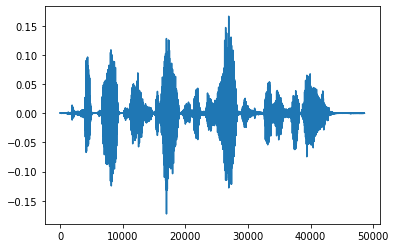

In [34]:
# TODO: figure why there is a spike at the beginning!
rec_a = x_rec.detach().cpu().numpy().ravel()
plt.plot(rec_a[700:-100])

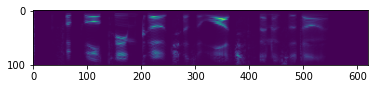

In [35]:
plt.imshow(feats_rec.detach().cpu().numpy()[0])
ipd.Audio(rec_a[700:-100], rate=sr)

In [36]:
# In this cell we modify the spectrogram and try to reconstruct the audio:
# we are squeezing the histogram 

# Run the original recording through the feature extraction
# pick 1s of audio
x_orig = x_torch.to('cuda')
feats_orig = feats(x_orig)

# Remove every-second timestep of the spectrogram
feats_orig = feats_orig[:,:,::2]

# Create a placeholder for reconstruction
# start with an empty recording approximately twce as long as the original
x_rec = torch.zeros((1, 12150), device='cuda')
x_rec.random_().mul_(0.1)
x_rec.requires_grad_(True)

optimizer = torch.optim.Adam([x_rec], lr=1e6)

for step in range(50000):
    optimizer.zero_grad()
    feats_rec = feats(x_rec)
    loss = torch.mean((feats_orig - feats_rec)**2)
    loss.backward()
    if (step % 1000) == 1:
        print(f'{step}: {loss.item()}, {optimizer.param_groups[0]["lr"]}')
    optimizer.step()
    optimizer.param_groups[0]['lr'] *= 0.9995

1: 102296247599104.0, 999500.0
1001: 16963325952.0, 606151.5954286763
2001: 13164980224.0, 367603.55841993843
3001: 951779840.0, 222934.9508969524
4001: 17336.10546875, 135199.97615107681
5001: 141735.5, 81992.67758468617
6001: 1156290.625, 49724.854758805915
7001: 313956.90625, 30155.877983501014
8001: 0.0055680787190794945, 18288.177640071663
9001: 0.007053693290799856, 11090.953530777855
10001: 0.006219012662768364, 6726.162258635607
11001: 0.006321847438812256, 4079.1135409545936
12001: 0.015732089057564735, 2473.7980798242515
13001: 0.008060472086071968, 1500.246776241984
14001: 0.0032100121024996042, 909.8318929022546
15001: 0.0032464631367474794, 551.7719394243064
16001: 0.0049844165332615376, 334.62475377170387
17001: 0.004179901909083128, 202.9347957665288
18001: 0.007323292549699545, 123.07078561468107
19001: 0.004306470509618521, 74.63687148674273
20001: 0.011106359772384167, 45.263890674831394
21001: 0.005596882198005915, 27.450504800258283
22001: 0.007119298912584782, 16.6

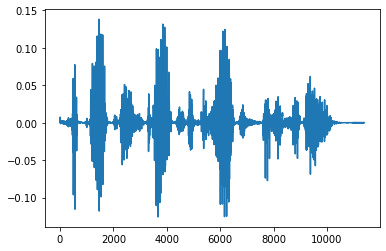

In [37]:
# TODO: figure why there is a spike at the beginning!
rec_a = x_rec.detach().cpu().numpy().ravel()
plt.plot(rec_a[650:-100])

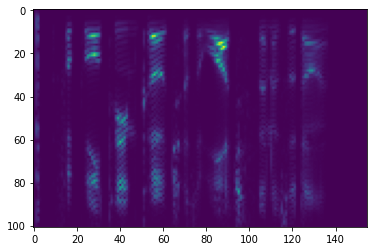

In [38]:
plt.imshow(feats_rec.detach().cpu().numpy()[0])
ipd.Audio(rec_a[650:-100], rate=sr)

# Record your own audio

<IPython.core.display.Javascript object>

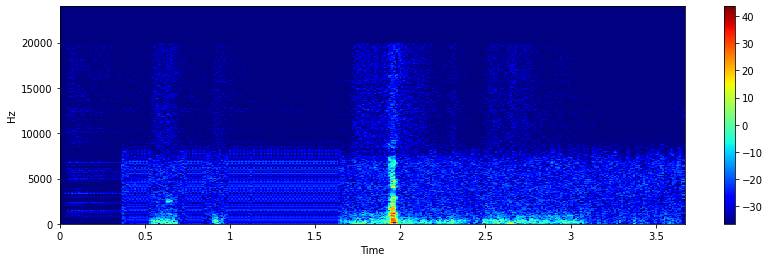

In [39]:
x, sr = record()

# The stft shows the evolution of the frequencies in the signal over time
fft_params = dict(n_fft=int(sr  * 25e-3), hop_length=int(sr * 10e-3))
S = librosa.stft(x, **fft_params)
S_db = librosa.amplitude_to_db(abs(S))
plt.figure(figsize=(14, 4))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='linear', hop_length=fft_params['hop_length'], cmap='jet')
plt.colorbar()

ipd.Audio(x, rate=sr)

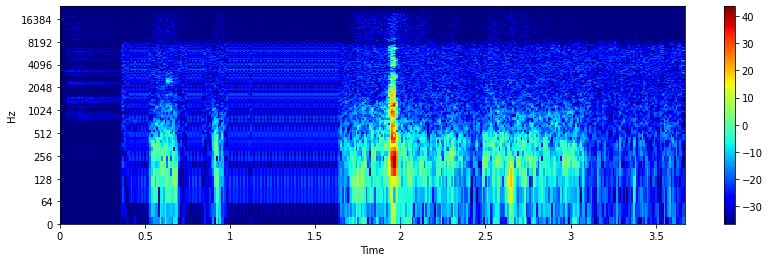

In [40]:
# The stft shows the evolution of the frequencies in the signal over time
fft_params = dict(n_fft=int(sr  * 25e-3), hop_length=int(sr * 10e-3))
S = librosa.stft(x, **fft_params)
S_db = librosa.amplitude_to_db(abs(S))
plt.figure(figsize=(14, 4))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log', hop_length=fft_params['hop_length'], cmap='jet')
plt.colorbar()